In [2]:
### Financial Econometrics II course SS 2018/2019 prof. M. Rubaszek ###

# We are going to create a portfolio of 2 chosen NASDAQ stocks and see how risky our investition is going to be #

library(quantmod)

# let's assume i like drinking pepsi whilst playing fifa so:

EA <- getSymbols("EA", auto.assign = FALSE) # EA
PEP <- getSymbols("PEP", auto.assign = FALSE) # PEPSI


Loading required package: xts
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.
'getSymbols' currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
'loadSymbols' to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.


Please see the Warning section of '?getSymbols.yahoo' for details.

This message is shown once per session and may be disabled by setting
options("getSymbols.yahoo.warning"=FALSE).


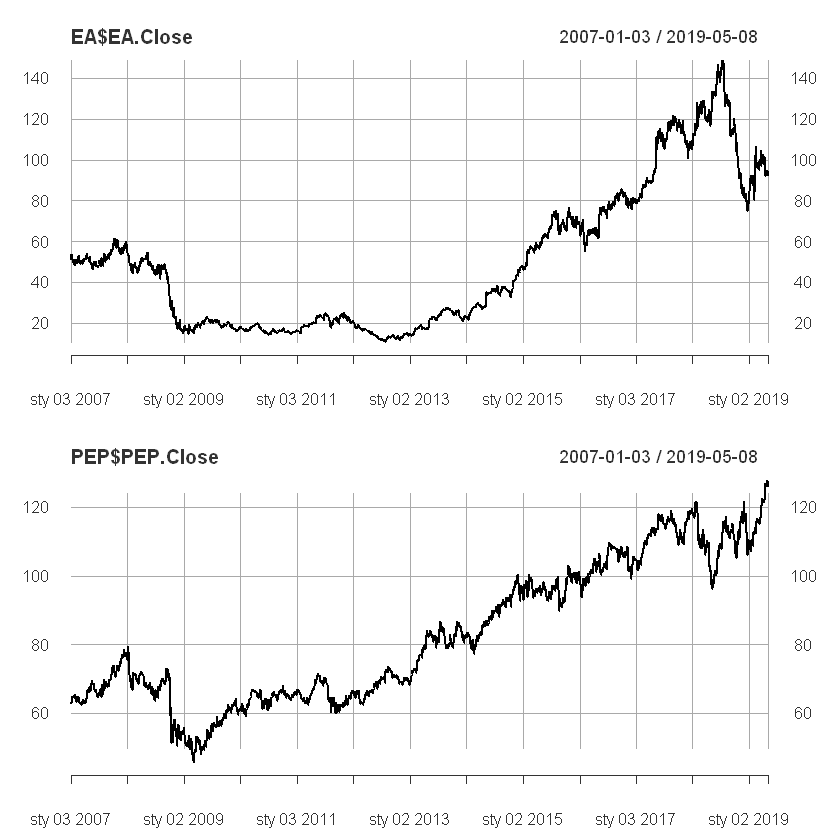

In [3]:
# Now we can look at the time series of those stocks over past 10 years #

par(mfrow=c(2,1), cex = 0.75, bty="l")
plot(EA$EA.Close)
plot(PEP$PEP.Close)

# As we can see there was a huge breakdown around 2008 #

In [4]:
# We can calculate the Pearsons correlation coefficient between the stocks #

cor(EA$EA.Close, PEP$PEP.Close)

,PEP.Close
EA.Close,0.8489474


In [5]:
# Some data manipulation #

Y<-merge(EA,PEP)
Y = Y[,c(4,10)]
head(Y)

           EA.Close PEP.Close
2007-01-03    51.05     62.72
2007-01-04    53.67     63.15
2007-01-05    53.07     62.95
2007-01-08    52.88     63.09
2007-01-09    52.70     63.35
2007-01-10    53.68     64.15

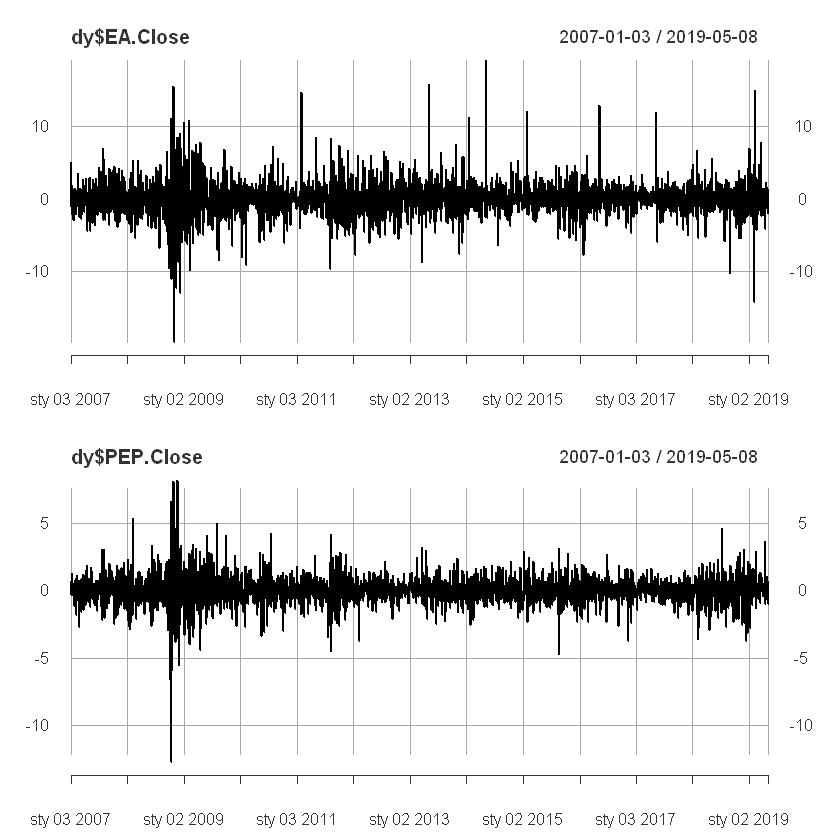

In [6]:
#Let's look at differences of log returns of the stocks#

dy  <- 100*diff(log(Y))
par(mfrow=c(2,1), cex=0.7, bty="l", lwd=1)
plot(dy$EA.Close)
plot(dy$PEP.Close)

# As expected there was a period of high volatility around 2008 #
# We can observe some relativly calm periods and some with higher volatility #
# Can one say 2018/2019 was also a bit nervous? #

In [22]:
## Creating portfolio ##

# Let's choose weights of our porfolio #
# For me pepsi > fifa so: #

w   <- c(0.35, 0.65)

# Let's create a variable with returns of ours portfolio over past 10 years
r   <- zoo(dy%*%w,index(dy))
R   <- as.numeric(coredata(r))
r[1] = 0 # in order to avoid NAs
R[1] = 0 # -||-

## The most important thing for every investor ##

# Portfolio valeu over time #
P   <- exp(cumsum(r/100))

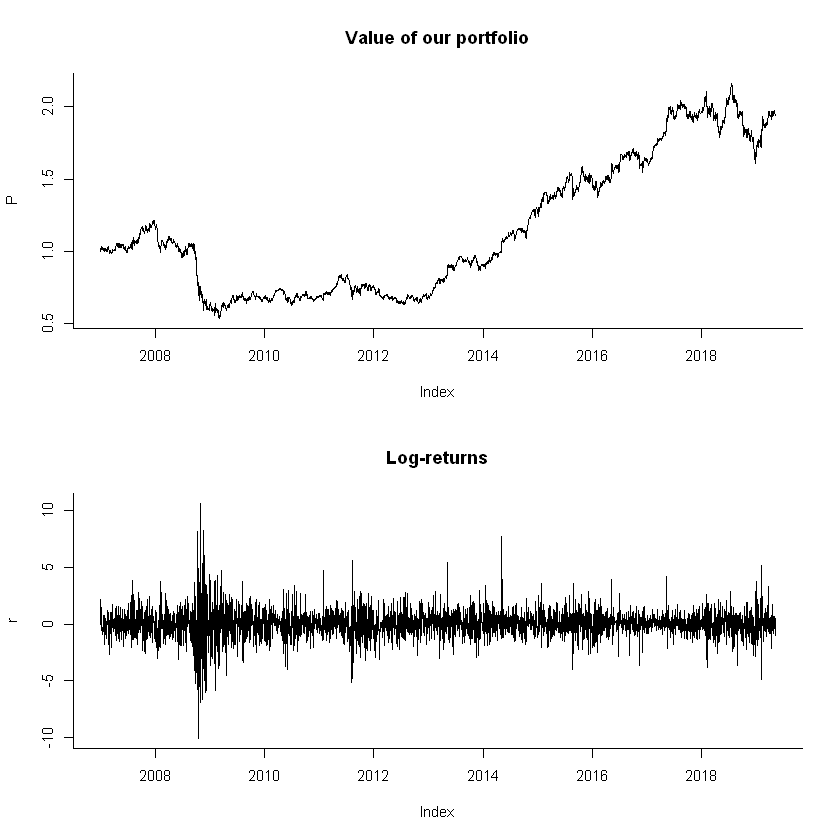

In [23]:
# Now we can visualise our portfolio #

par(mfrow=c(2,1), cex = 0.75, bty="l")
plot(P, main="Value of our portfolio")
plot(r, main="Log-returns")


Loading required package: rugarch
Warning message:
"package 'rugarch' was built under R version 3.5.2"Loading required package: parallel

Attaching package: 'rugarch'

The following object is masked from 'package:stats':

    sigma



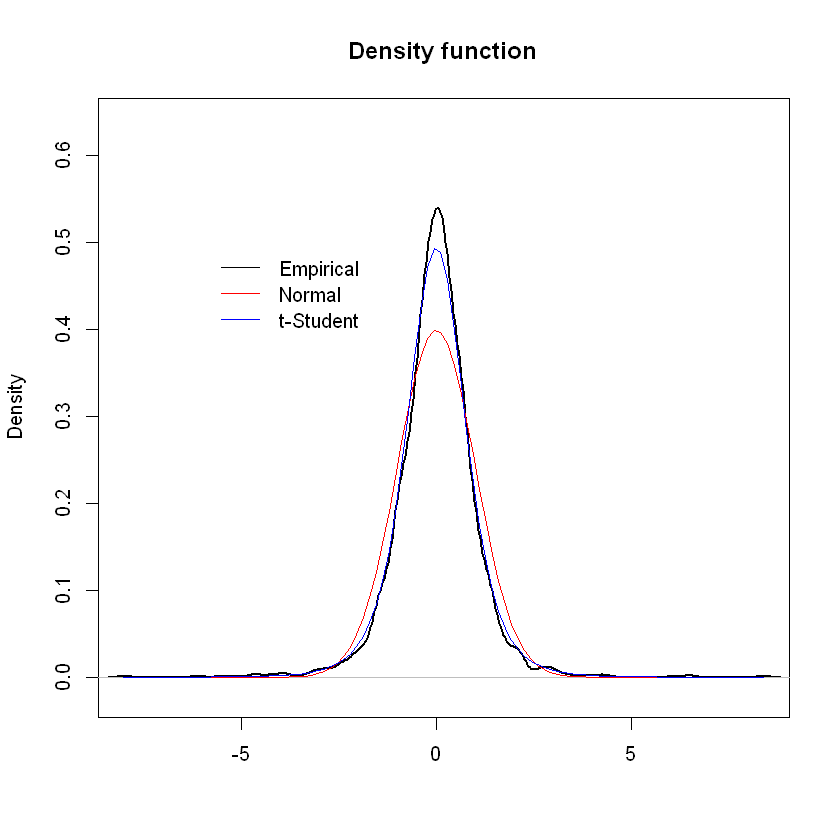

In [29]:
## Let's look at the distribution of standarized returns of our portfolio compared to N(0,1) and t-Student with estimated v


require(rugarch)

plot(d, main="Density function", xlim = xlim, ylim = ylim, lwd=2,xlab="") 

xfit <-seq(min(Rstar),max(Rstar),length=100); 

# normal distribution
yfit <-dnorm(xfit,0,1);               
lines(xfit, yfit, lwd=1, col="red") 

# t-Student distribution
# kurtosis(R) = 3 + 6/(v-4)
v = 4 + 6/(kurtosis(R)-3)
yfit <-ddist("std",y=xfit,shape=v);   
lines(xfit, yfit, lwd=1, col="blue") 

# The alternative way below #
#yfit <-ddist("std",y=xfit,shape=5);   lines(xfit, yfit, lwd=1, col="blue") 

legend(-6,0.5,c("Empirical","Normal","t-Student"), col=c("black","red","blue"),bty="n",lty=c(1,1,1))



# What can we say about standarized returns distribution? It's definitely leptokurtic #

In [12]:
### Let's have a look at some basic statistics ###


require(moments)
require(tseries)

dates <- index(Y)
Nyear <- 365/as.numeric(mean(diff(dates)))
mu    <- mean(r)*Nyear
sig   <- sd(r)*sqrt(Nyear) 
mom <- as.data.frame(c(Nyear,mu,sig,min(r),max(r), skewness(r), kurtosis(r),jarque.bera.test(r)$stat))
rownames(mom) <- c("N","mu","sig","min","max","skewness","kurtosis", "JB test"); colnames(mom)="value"

require(knitr)
kable(mom, digits=2)

Loading required package: tseries
Warning message:
"package 'tseries' was built under R version 3.5.2"Loading required package: knitr
Warning message:
"package 'knitr' was built under R version 3.5.3"



|         |   value|
|:--------|-------:|
|N        |  251.56|
|mu       |    5.40|
|sig      |   20.11|
|min      |  -10.14|
|max      |   10.68|
|skewness |   -0.08|
|kurtosis |   10.06|
|JB test  | 6460.14|

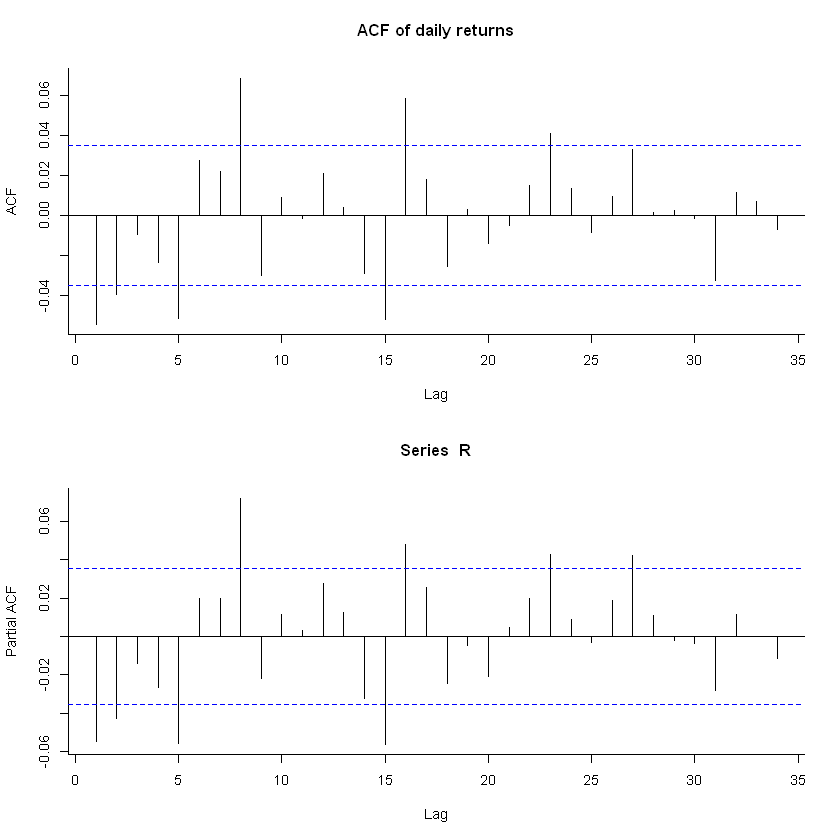

In [82]:
# Is there any autocorrelation within returns? #

#  First thing check how ACF and PACF pltos look like #

require(forecast)
par(mfrow=c(2,1), cex=0.7, bty="l", lwd=1)
Acf(R, main="ACF of daily returns" )
Pacf(R)



In [16]:
#Let's formalize it with some tests #

Box.test(R, lag = 20, type = c("Ljung-Box"))

#  Box- Ljung claims our data exhibits some serial correlation :( #


	Box-Ljung test

data:  R
X-squared = 72.929, df = 20, p-value = 6.012e-08


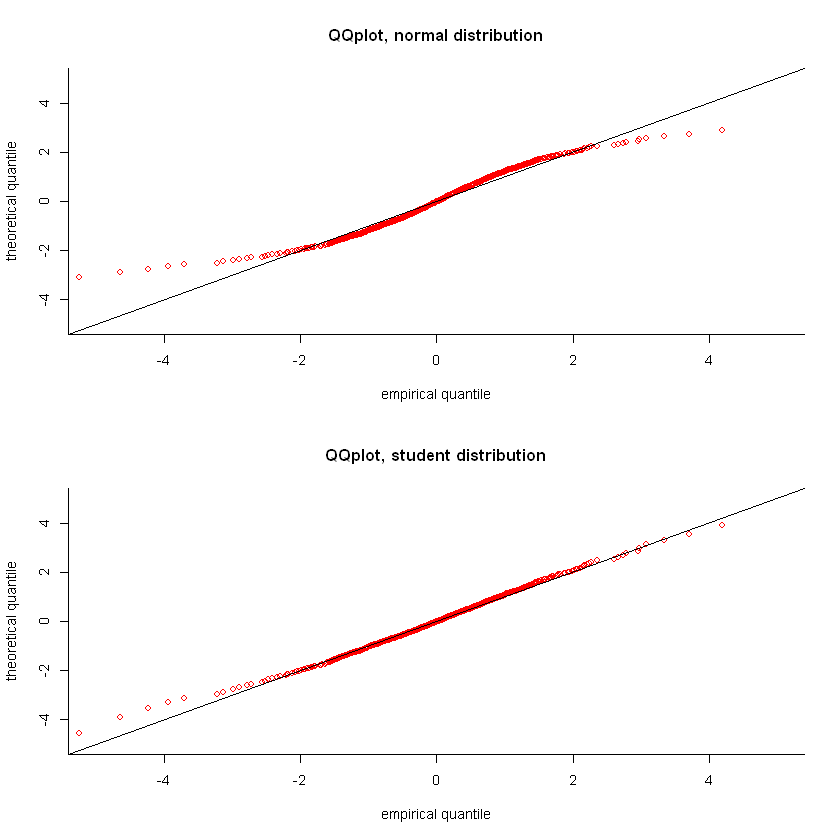

In [84]:
## We can see how QQ plots look like - using normal distribution as well as t-distribution ##


q            <- seq(0.001, 0.999, 0.001)

Qteo         <- qnorm(q)        # Normal distribution
Qteo1  <- qdist("std",p=q,shape=5) # SCALED t-distribution

Qemp         <- quantile(Rstar,q)         # our data

lim0    <- c(-5,5)                         
par(mfrow=c(2,1), cex = 0.7, bty="l")

plot(Qemp,Qteo, main="QQplot, normal distribution", col="red", xlim = lim0, ylim = lim0,
     xlab="empirical quantile", ylab="theoretical quantile") 
abline(a=0,b=1, lwd=1)

plot(Qemp,Qteo1, main="QQplot, student distribution", col="red", xlim = lim0, ylim = lim0,
     xlab="empirical quantile", ylab="theoretical quantile") 
abline(a=0,b=1, lwd=1)

#Important note#

## t-distribution fits our data clearly better ##

In [87]:
### So let's calculate Value at Risk of our portfolio applying different strategies ###


### 5 % Value at Risk -> Normal Distribution vs Student Distribution vs Historical simulation ###

# normal distribution 
p   <- 0.05      # tolerance level
m   <- mean(R) 
s   <- sd(R)
VaRnorm     <- qnorm(p)*s + m             
ESnorm      <- m - s*dnorm(qnorm(p))/p    
qf          <- function(x) qdist("norm", p=x)
ESnorm1     <- m + s*(1/p * integrate(qf, 0, p)$value) 

# t-Student distribution 
 v = 4 + 6/(kurtosis(R)-3)               # GMM estimate
# v <- fitdist("std", R)$pars["shape"]    # ML estimate
#v = 5

VaRt  <- m + s*qdist("std",shape=v,p=p)
qf    <- function(x) qdist("std", p=x, shape=v)
ESt   <- m + s*(1/p * integrate(qf, 0, p)$value) 

# Historical simulation
R0    <- sort(R)              
N0    <- floor(length(R0)*p)                            
VaRhs <- R0[N0]                      # compare to: quantile(R,p)
EShs  <- mean(R0[1:N0])        

tat <- as.data.frame(c(VaRnorm,VaRt,VaRhs,ESnorm,ESt,EShs))
rownames(tat) <- c("Value at Risk normal distribution","Value at Risk  t-distribution","Value at Risk  historical",
                   "Expected Shortfall normal distribution",
                   "Expected Shortfall t-distribution","Expected Shortfall historical") 

colnames(tat)="value"
kable(tat, digits=2)




### 5% Var is the biggest for normal distribution ###
### The biggest ES is for historical distribution ###



|                                       | value|
|:--------------------------------------|-----:|
|Value at Risk normal distribution      | -2.06|
|Value at Risk  t-distribution          | -1.95|
|Value at Risk  historical              | -1.89|
|Expected Shortfall normal distribution | -2.59|
|Expected Shortfall t-distribution      | -2.82|
|Expected Shortfall historical          | -2.93|

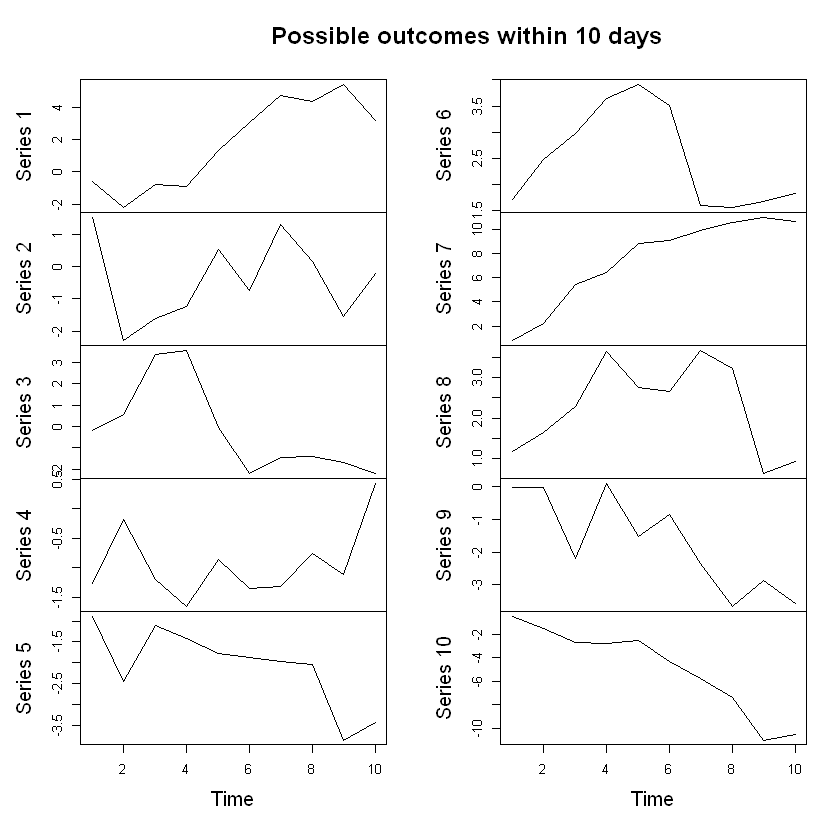

In [80]:
# 3b. VaR/ES for H-steap ahead horizon: 
# Normal, t-Student, Historical Simulation
######################################################
### Now we can compute VaR and ES for 10 days ahead using 

H = 10 

## a) normal distribution: SQUARE ROOT OF TIME - ANALITICAL FORMULA ##

VaRHnorm <- sqrt(1:H)*qnorm(p)*s + (1:H)*m    
ESHnorm  <- (1:H)*m - sqrt(1:H)*s*dnorm(qnorm(p))/p    

## It's very convenient because we can use analitical formula - there is no need to use simulations ##


## b) t-distribution: Monte Carlo simulations ##

# We cannot derive it analitically so we have to apply MC to see how the distribution of cumulated returns may look like ##

Nsim    <- 10000
Rdraws  <- matrix(rdist(distribution="std", Nsim*H, mu = m, sigma = s, shape = v),H,Nsim) 
RdrawsC <- apply(Rdraws,2,cumsum)               # cumualted changes

VaRHt <- rep(NaN,H)
ESHt <- rep(NaN,H)
M0  <- floor(Nsim*p)     # observation for p-th quantile 

for(h in 1:H){
  temp   = sort(RdrawsC[h,])
  VaRHt[h] = temp[M0]
  ESHt[h]  = mean(temp[1:M0])
}


### Let's look at 10 possible paths ###

plot.ts(RdrawsC[,1:10], main = "Possible outcomes within 10 days")



In [50]:
## The same as above but in function form ##

RdrawsToVaRES <- function(RDraws,p){
  H    <- dim(Rdraws)[1]
  NSim <- dim(Rdraws)[2]
  RdrawsC <- apply(Rdraws,2,cumsum)               # cumualted changes
  VaR  <- ES <- rep(NaN,H)
  M0  <- floor(Nsim*p)     # observation for p-th quantile 
  for(h in 1:H){
    temp   = sort(RdrawsC[h,])
    VaR[h] = temp[M0]
    ES[h]  = mean(temp[1:M0])
  }
  return(list(VaR=VaR,ES=ES)) 
}


## c) Historical Simulation: Bootstrap ##

# We will use bootsrap to obtain a distribution of cumulated returns using historical data #

Rdraws  <- matrix(sample(R, Nsim*H, replace=TRUE),H,Nsim) 
temp   <- RdrawsToVaRES(RDraws,p)
VaRHhs <- temp$VaR
ESHhs  <- temp$ES

Ahead <- 1:10
beb <- cbind(Ahead,VaRHnorm,VaRHt,VaRHhs,ESHnorm, ESHt, ESHhs)

kable(beb,digit = 2)


## For 10 days ahead the biggest Var (5%) is for t-distribution ###

## For 10 days ahead we have the biggest ES  for historical simulation ###

## As we can see the value of Var increases rapidly from about -2 for H=1 to over 6 for H=10 ##



| Ahead| VaRHnorm| VaRHt| VaRHhs| ESHnorm|  ESHt| ESHhs|
|-----:|--------:|-----:|------:|-------:|-----:|-----:|
|     1|    -2.06| -2.01|  -1.90|   -2.59| -2.87| -3.09|
|     2|    -2.91| -2.80|  -2.80|   -3.66| -3.91| -4.15|
|     3|    -3.55| -3.52|  -3.37|   -4.47| -4.71| -4.88|
|     4|    -4.09| -4.09|  -3.94|   -5.15| -5.41| -5.60|
|     5|    -4.56| -4.58|  -4.46|   -5.74| -6.04| -6.25|
|     6|    -4.98| -5.00|  -4.97|   -6.28| -6.58| -6.79|
|     7|    -5.37| -5.37|  -5.29|   -6.77| -7.08| -7.25|
|     8|    -5.73| -5.74|  -5.63|   -7.23| -7.65| -7.70|
|     9|    -6.06| -6.14|  -5.94|   -7.65| -8.00| -8.12|
|    10|    -6.38| -6.40|  -6.33|   -8.06| -8.38| -8.50|

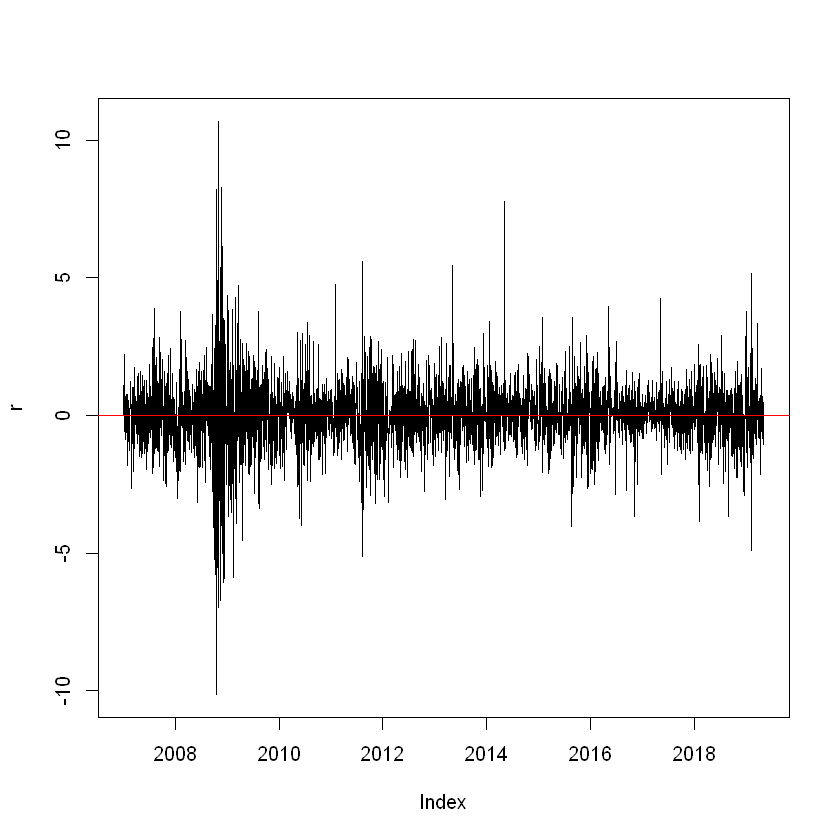

In [51]:
# Volatility clustering #
###########################################


# Let's take a look at the returns of our portfolio and find out whether our data exhibits volatility clustering #

plot(r); abline (h = 0 , col = "red")


# 2008 was very nervous - that's for sure #
# Then we can observe some periods of higer volatility in the next few years #
# It may mean there is conditional heteroscedasticity in the returns #


	Box-Ljung test

data:  R^2
X-squared = 3744.2, df = 20, p-value < 2.2e-16


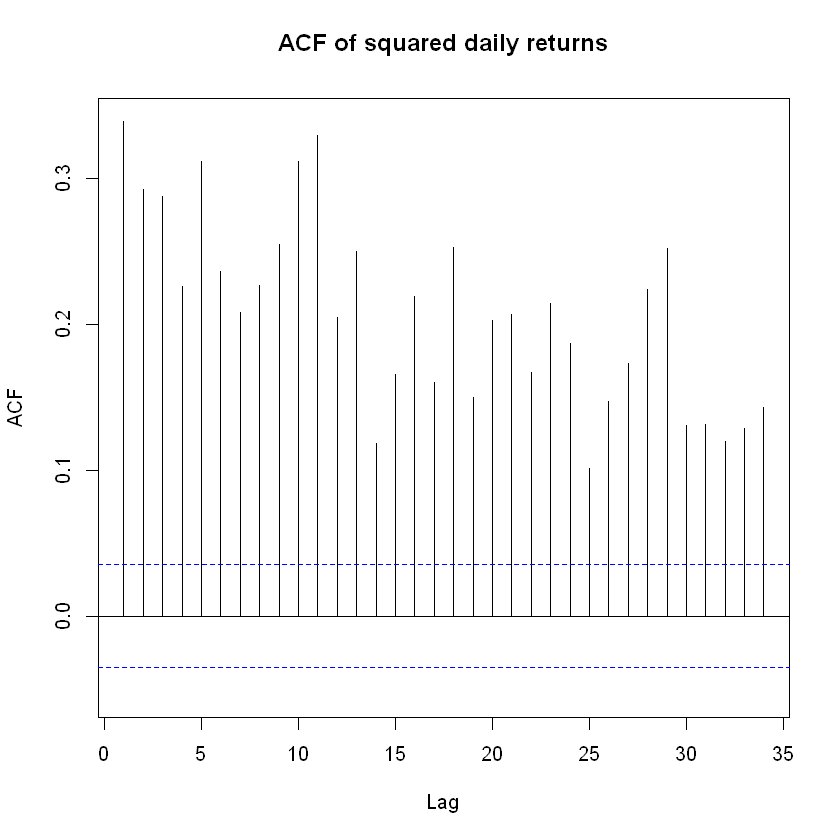

In [52]:
Acf(R^2, main="ACF of squared daily returns" )
Box.test(R^2, lag = 20, type = c("Ljung-Box"))

### Box-Ljung suggest the ARCH effect is present ###

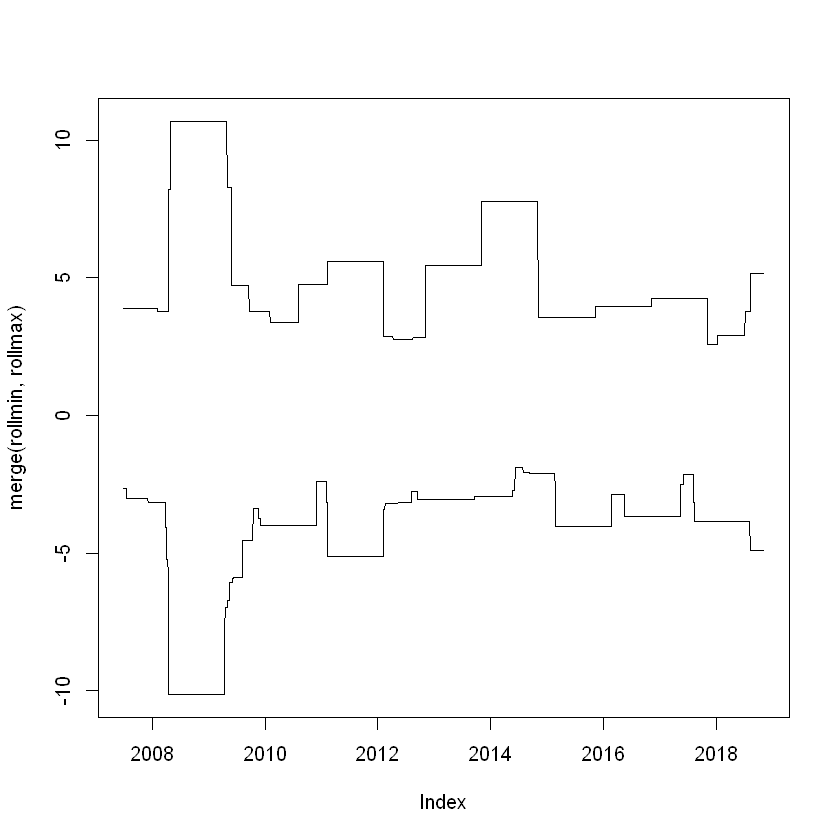

In [53]:
# Let's detect the periods of increased volatility #


# min-max spread
rollmin <- rollapply(r, width=Nyear, min, by=1)
rollmax <- rollapply(r, width=Nyear, max, by=1)
plot(merge(rollmin,rollmax),screens=c(1,1))

#2008 obviously
# about 2011
# maybe 2014 ?

#### Is 2019 going to be nervous? ####

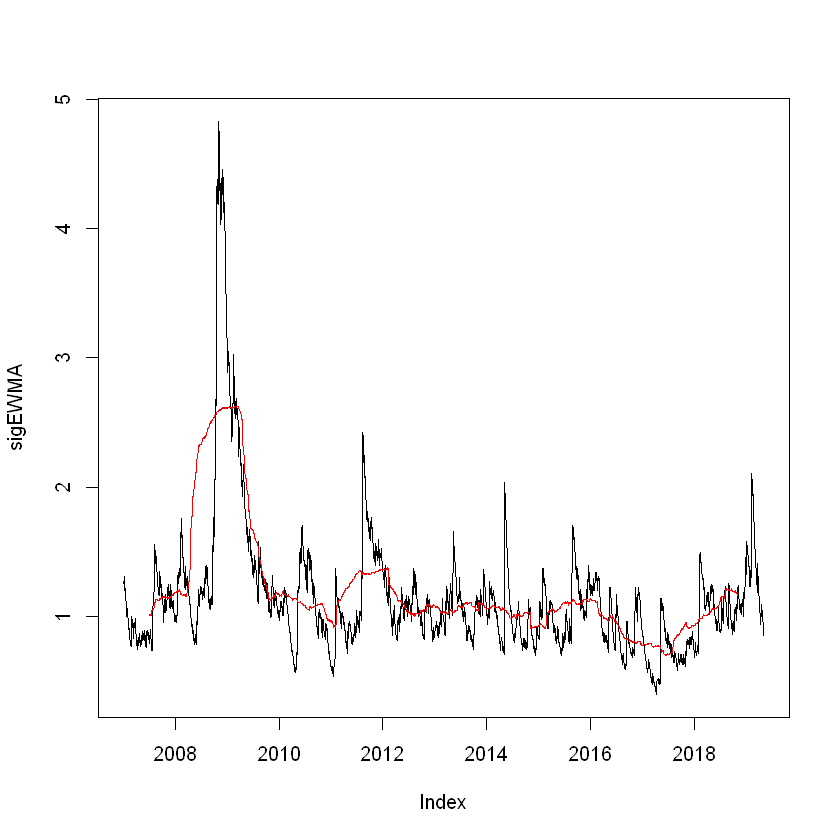

In [56]:
# We can try to model the volatility #


# Firstly let's have a look at 2 basic (?) strategies #



### Rolling Standard Deviation (1 year window) ###


sigROLL <- rollapply(r, width=Nyear, sd, by=1)

# The biggest problem with rolling SD is the fact once the period is over and some observations are not loger included
# the curve may suddenly drop - is it reasonable?




#### Exponentially Weighted Moving Average EVMA / riskMetrics (developed by JP Morgan) ####


# We can try to adress that problem using EVMA -
# observation have influence all the time but with smaller and smaller weight #



lambda      <- 0.94                         

 # smoothing parameter was initially calibrated by JP Morgan's economists
 # See RiskMetrics 1994


temp        <- rep(0,length(R))
temp[1]     <- var(R)                        # starting point -> srednia z proby
for (t in 2:length(R)){             
  temp[t] = lambda * temp[t-1]  + (1-lambda) * R[t-1]^2
}
sigEWMA      <- zoo(temp^0.5,order.by=index(r))

plot(sigEWMA)
lines(sigROLL,col='red')

In [89]:
### OK, let's move to my favourite part - GARCH model ###



## 1) Specification -> (1,1) so the most common one

spec0 = ugarchspec(variance.model=list(model="sGARCH", garchOrder=c(1,1)), 
                   mean.model=list(armaOrder=c(0,0), include.mean=TRUE),  
                   distribution.model="norm")


## 2) Fitting the data

fit0 = ugarchfit(data=r, spec=spec0) # solver="nlminb"

fit0
sigGARCH <- as.zoo(sigma(fit0))


# We can also compute the equilibrium level ! #

sig2eq = fit0@fit$coef["omega"]/(1-fit0@fit$coef["alpha1"]-fit0@fit$coef["beta1"])

(sqrt(sig2eq))

# It's about 1.18 #


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.053561    0.018376   2.9147 0.003560
omega   0.068857    0.016002   4.3029 0.000017
alpha1  0.101219    0.016893   5.9918 0.000000
beta1   0.849670    0.025339  33.5325 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.053561    0.017679   3.0295 0.002449
omega   0.068857    0.035484   1.9405 0.052316
alpha1  0.101219    0.034562   2.9286 0.003405
beta1   0.849670    0.053994  15.7364 0.000000

LogLikelihood : -4744.983 

Information Criteria
------------------------------------
                   
Akaike       3.0560
Bayes        3.0637
Shibata      3.0560
Hannan-Quinn 3.0588

Weighted

omega 
1.184085

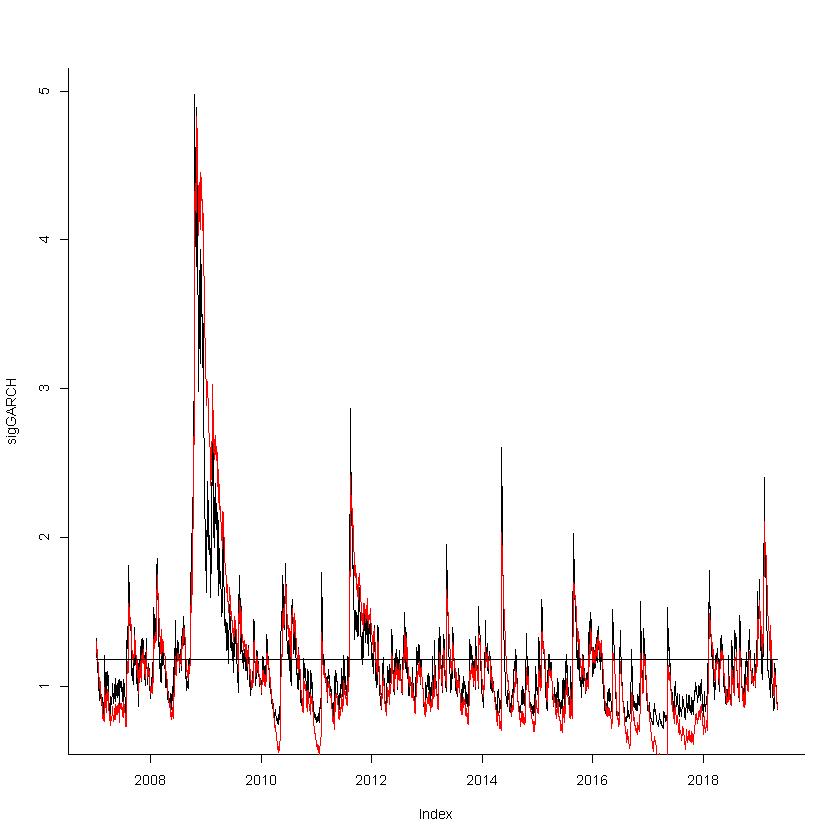

In [59]:
# Red line presents volatility modeled by EWMA, the black one accounts for GARCH(1,1) model

# Horizontal line is set at equilibrium level computed from GARCH model #

par(mfrow=c(1,1), cex = 0.7, bty="l")
plot(sigGARCH)
lines(sigEWMA,col='red')
lines(zoo(sqrt(sig2eq),index(sigGARCH)))


	Box-Ljung test

data:  u^2
X-squared = 10.362, df = 12, p-value = 0.5842


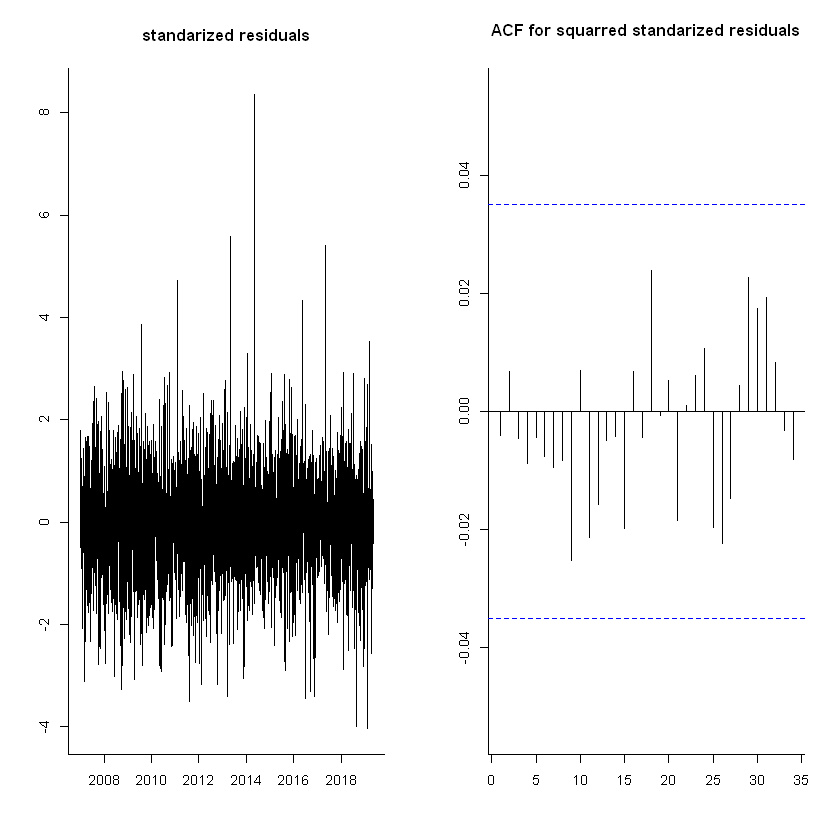

In [60]:
# Now we can standarize the residuals from GARCH(1,1) model


u   <- as.zoo(residuals(fit0)/sigma(fit0))

par(mfrow=c(1,2), cex=0.7, bty="l", lwd=1)
plot(u, main="standarized residuals", xlab="", ylab="")
Acf(coredata(u)^2, main="ACF for squarred standarized residuals", xlab="", ylab="")

Box.test(u^2, lag=12, type='Ljung')


#That looks awesome I guess #
# Note: There is absolutely no serial correlation in standarized residuals #

# Our good friends Box and Ljungs confirmed that fact #
# Thanks guys! #


please wait...calculating quantiles...


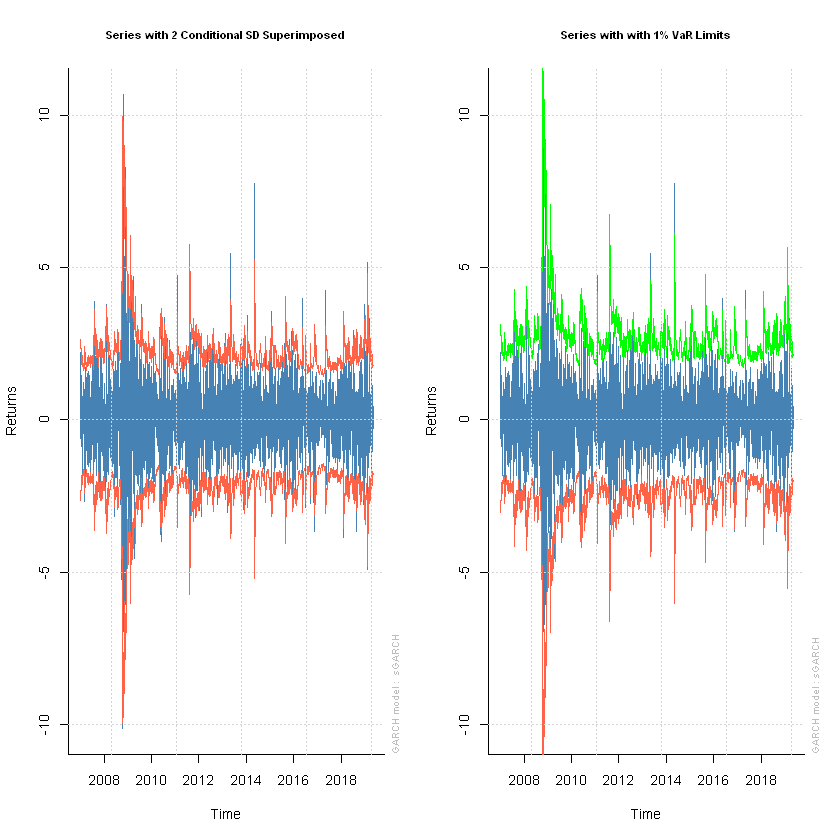

In [61]:
par(mfrow=c(1,2), cex=0.7, bty="l", lwd=1)
plot(fit0, which=1)
plot(fit0, which=2)


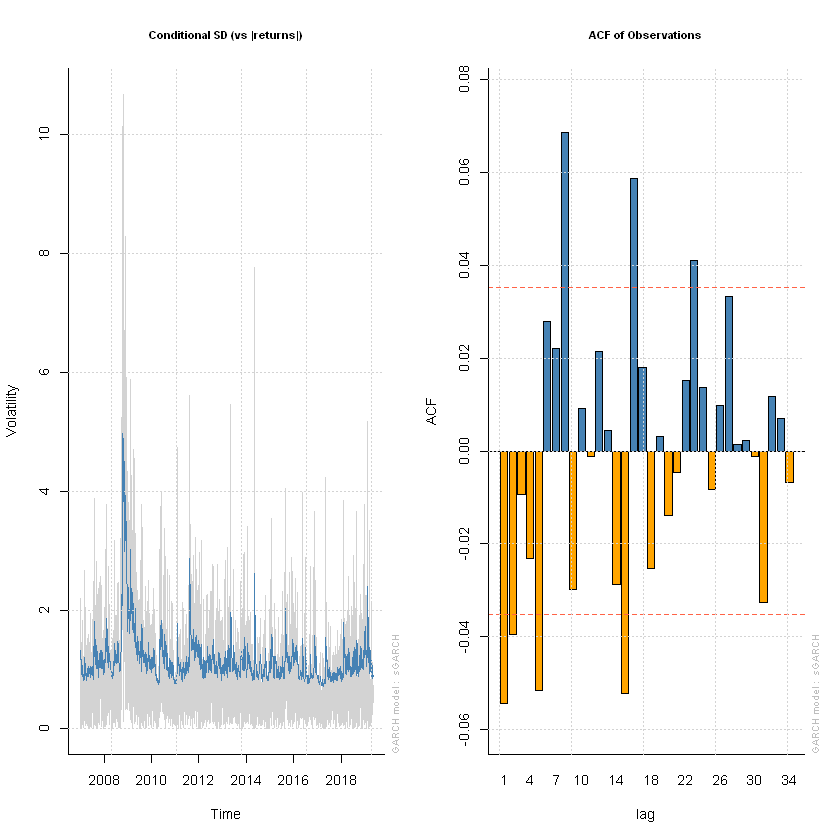

In [62]:
par(mfrow=c(1,2), cex=0.7, bty="l", lwd=1)
plot(fit0, which=3)
plot(fit0, which=4)

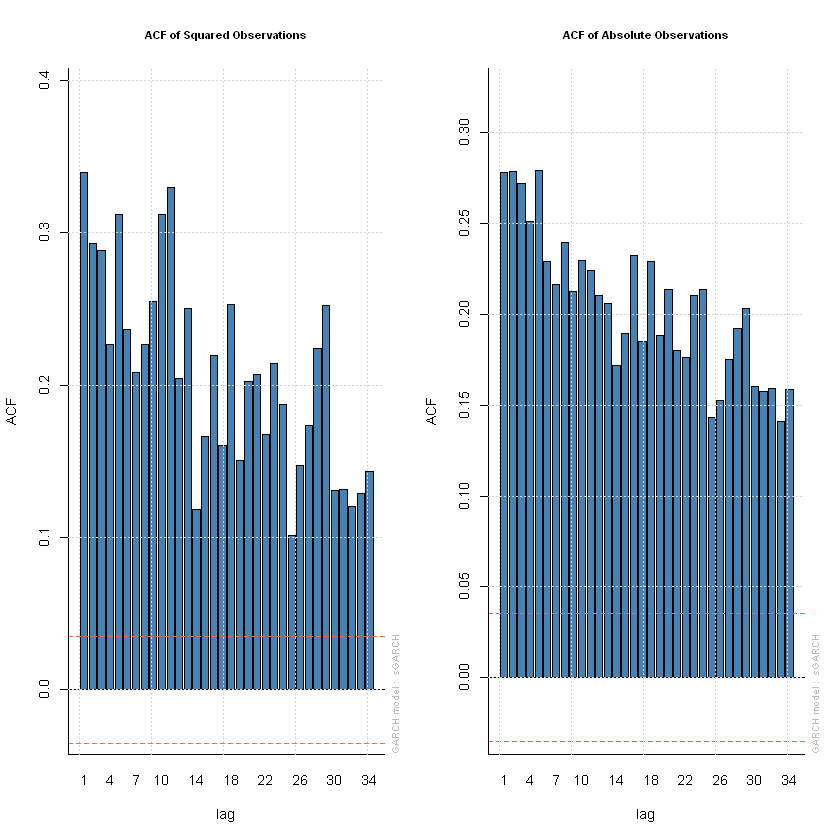

In [81]:
par(mfrow=c(1,2), cex=0.7, bty="l", lwd=1)
plot(fit0, which=5)
plot(fit0, which=6)

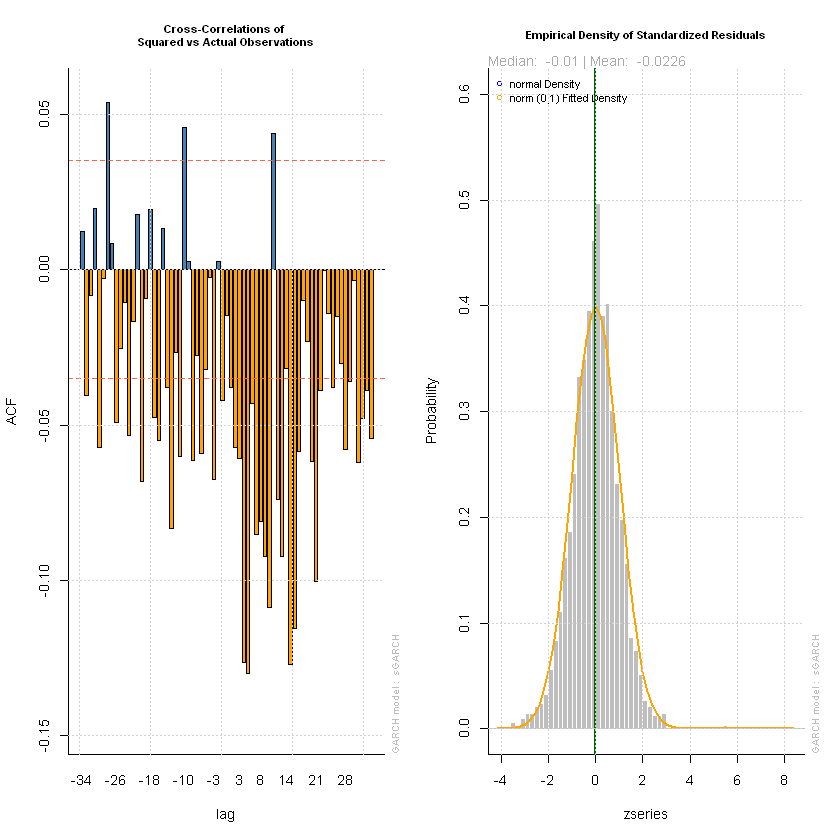

In [65]:
par(mfrow=c(1,2), cex=0.7, bty="l", lwd=1)
plot(fit0, which=7)
plot(fit0, which=8)

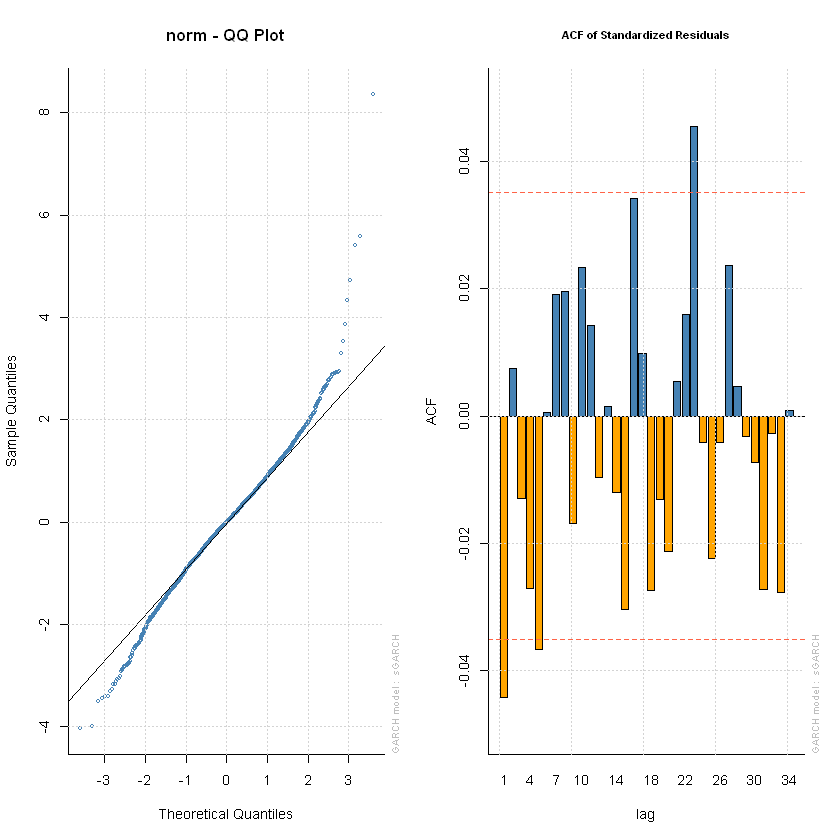

In [66]:
par(mfrow=c(1,2), cex=0.7, bty="l", lwd=1)
plot(fit0, which=9)
plot(fit0, which=10)

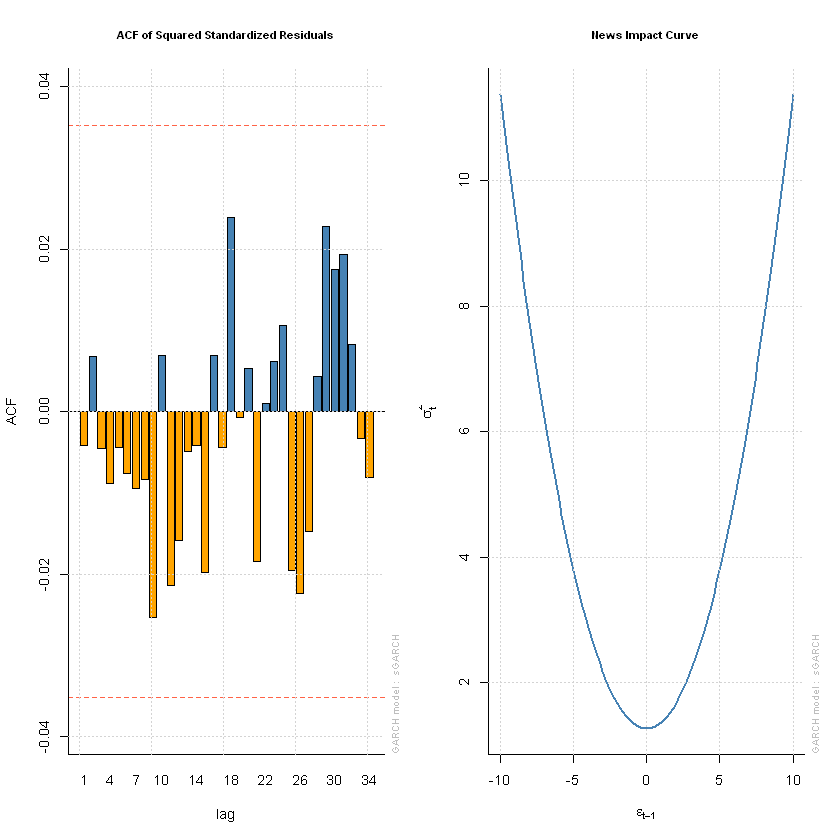

In [67]:
par(mfrow=c(1,2), cex=0.7, bty="l", lwd=1)
plot(fit0, which=11)
plot(fit0, which=12)

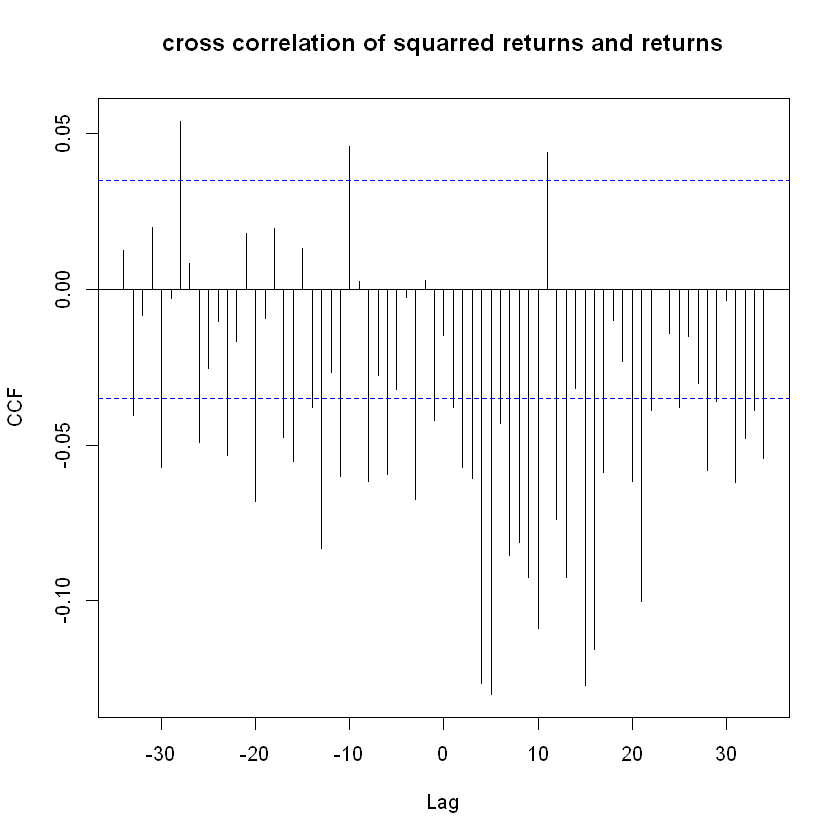

In [68]:
# Leverage effect
Ccf(R^2,R, type="correlation", main="cross correlation of squarred returns and returns")


In [70]:
### LAG SELECTION - IT MAY TAKE 1 or 2 MIN

LagSel <- function(x, Pmax=4, Qmax=4, crit="SIC", dist="norm"){
  IC <- matrix(NA, Pmax, Qmax+1)
  for(p in 1:Pmax){
    for(q in 0:Qmax){
      
      spec = ugarchspec(variance.model=list(model="sGARCH", garchOrder=c(p,q)), 
                        mean.model=list(armaOrder=c(0,0), include.mean=TRUE),  
                        distribution.model=dist)
      fit  = ugarchfit(data=x, spec=spec)
      if(crit == "AIC"){IC[p,q+1] <- infocriteria(fit)[1] }
      if(crit == "SIC"){IC[p,q+1] <- infocriteria(fit)[2] }
      if(crit == "HQ"){	IC[p,q+1] <- infocriteria(fit)[4] }
    }
  }
  rownames(IC) <- paste('p=',1:Pmax, sep="")
  colnames(IC) <- paste('q=',0:Qmax, sep="")
  return(IC)
}

LagSel(r,4,4,crit="SIC", dist="std")
LagSel(r,4,4,crit="SIC", dist="norm")

,q=0,q=1,q=2,q=3,q=4
p=1,3.094726,3.017972,3.020572,3.022554,3.024895
p=2,3.071561,3.020626,3.023160,3.024912,3.026462
p=3,3.054831,3.022971,3.025505,3.027499,3.029780
p=4,3.048855,3.025656,3.028190,3.030046,3.032367


,q=0,q=1,q=2,q=3,q=4
p=1,11.733808,3.063749,3.066188,3.067966,3.070162
p=2,5.479932,3.066393,3.068775,3.070526,3.072657
p=3,3.105756,3.068718,3.071098,3.073113,3.075245
p=4,3.097166,3.071422,3.073804,3.075758,3.077832


In [72]:
# optimal lags - we could use a function lag selection but we personally prefer smaller models so (1,1) is just fine
pq   = c(1,1)
PQ   = c(0,0)
dist = "std"


# assymetric models
spec.e   = ugarchspec(variance.model=list(model="eGARCH", garchOrder=pq), 
                      mean.model=list(armaOrder=PQ, include.mean=TRUE),  
                      distribution.model=dist)

spec.gjr = ugarchspec(variance.model=list(model="gjrGARCH", garchOrder=pq), 
                      mean.model=list(armaOrder=PQ, include.mean=TRUE),  
                      distribution.model=dist)

fit.e   = ugarchfit(data=r, spec=spec.e)    # solver="nlminb"
fit.gjr = ugarchfit(data=r, spec=spec.gjr)

# GARCH-in-Mean #ugarchspec(variance.model=list(model="gjrGARCH", garchOrder=pq), 
                      mean.model=list(armaOrder=PQ, include.mean=TRUE),  
                      distribution.model=dist)
mod = "gjrGARCH"
spec.m = ugarchspec(variance.model=list(model=mod, garchOrder=pq), 
                    mean.model=list(armaOrder=PQ, include.mean=TRUE, archm = TRUE), distribution.model=dist)
fit.m  = ugarchfit(data=r, spec=spec.m)

IC <- cbind(infocriteria(fit0), infocriteria(fit.e), infocriteria(fit.gjr), infocriteria(fit.m))
colnames(IC) <- c("GARCH", "eGARCH", "gjrGARCH","GARCH-in-mean")
IC


,GARCH,eGARCH,gjrGARCH,GARCH-in-mean
Akaike,3.055973,2.989840,2.992204,2.992669
Bayes,3.063749,3.001503,3.003867,3.006276
Shibata,3.055970,2.989832,2.992196,2.992659
Hannan-Quinn,3.058765,2.994028,2.996392,2.997555


In [79]:
#Bayes criterion is our favourite so we choose gjr GARCH as the benchmark model:

spec2 = ugarchspec(variance.model=list(model="gjrGARCH", garchOrder=pq), 
                   mean.model=list(armaOrder=PQ, include.mean=TRUE), distribution.model=dist)


fit2  = ugarchfit(data=r, spec=spec2)


# 8. Analitical VaR/ES for h=1 from the best GARCH model
########################################################

p <- 0.05                        # tolerance level
v <- fit2@fit$coef["shape"]      # shape of t-distribution

# help(ugarchforecast)
fct2 <- ugarchforecast(fit2,data=r, n.ahead = 1)
sig <- sigma(fct2)
mu  <- fitted(fct2)

qf   <- function(x) qdist("std", p=x, shape=v)
#qf   <- function(x) qdist("norm", p=x)
(VaRgarch <- mu + sig*qdist("std", p, shape=v))
(ESgarch  <- mu + sig*(1/p * integrate(qf, 0, p)$value)  )

,2019-05-08
T+1,-1.420171


,2019-05-08
T+1,-1.94496
